# Data Extraction and cleaning

- get data from restricted folder


In [109]:
# pip install python-calamine
import pandas as pd
from pathlib import Path
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()



In [201]:
ts = dict()
DATAFOLDER = Path('restricted/yearend/')
filenames = [f for f in DATAFOLDER.glob('FY*.xlsx')]

for fn in filenames:
    fy = fn.name[:4]
    print(f"{fy}+++++++++++++++++++++")
    df = pd.read_excel(fn, sheet_name='Sheet1', skiprows=0, engine='calamine')
    print('rows in df:', len(df))
    df = df.loc[df.BUSegment.fillna('').str.contains('FA Product')]
    print('rows in df (filtered "FA Product"):', len(df))
    cols = ['PostDate', 'AKZ', 'Territory', 'GBK', 'VBEZ', 
            'CustomerChineseName', 'SoldToPartyCustomerType', 'AssignedCustomerName', 'AssignType']
    grp = df.groupby(cols)[['OR', 'TO']].sum().reset_index()
    print('grouped rows:', len(grp))
    grp = grp.loc[(grp[['OR', 'TO']]!=0).any(axis=1)]
    print('grouped rows without all Zero:', len(grp))
    grp['PostDate'] = pd.to_datetime(grp.PostDate)
    ts[fy] = grp
ts = pd.concat(ts.values(), keys=ts.keys()).droplevel(-1).reset_index()
ts

FY18+++++++++++++++++++++
rows in df: 35956
rows in df (filtered "FA Product"): 12859
grouped rows: 12813
grouped rows without all Zero: 12705
FY19+++++++++++++++++++++
rows in df: 37570
rows in df (filtered "FA Product"): 13977
grouped rows: 13971
grouped rows without all Zero: 13771
FY20+++++++++++++++++++++
rows in df: 53193
rows in df (filtered "FA Product"): 24172
grouped rows: 22120
grouped rows without all Zero: 21962
FY21+++++++++++++++++++++
rows in df: 61237
rows in df (filtered "FA Product"): 28302
grouped rows: 25602
grouped rows without all Zero: 25497
FY22+++++++++++++++++++++
rows in df: 94512
rows in df (filtered "FA Product"): 51299
grouped rows: 48256
grouped rows without all Zero: 47123
FY23+++++++++++++++++++++
rows in df: 121717
rows in df (filtered "FA Product"): 49609
grouped rows: 46591
grouped rows without all Zero: 38860


,index,PostDate,AKZ,Territory,GBK,VBEZ,CustomerChineseName,SoldToPartyCustomerType,AssignedCustomerName,AssignType,OR,TO
0,FY18,2017-10-15,3004206200,RNE-HLJ,R111,280TL000,哈尔滨宇龙自动化有限公司,Wholesaler/Distributor(EWT),哈尔滨宇龙自动化有限公司,Direct,1259296.25,0.0
1,FY18,2017-10-15,3004206200,RNE-HLJ,R119,280TL000,哈尔滨宇龙自动化有限公司,Wholesaler/Distributor(EWT),哈尔滨宇龙自动化有限公司,Direct,668811.00,0.0
2,FY18,2017-10-15,3004209402,RNE-LNS,R111,280TN000,大连中巨控制系统有限公司,Wholesaler/Distributor(EWT),大连中巨控制系统有限公司,Direct,129168.39,0.0
3,FY18,2017-10-15,3004209452,RNE-LNS,R111,280TN000,大连中巨控制系统有限公司,Wholesaler/Distributor(EWT),大连中巨控制系统有限公司,Direct,113177.36,0.0
4,FY18,2017-10-15,3004209452,RNE-LNS,R119,280TN000,大连中巨控制系统有限公司,Wholesaler/Distributor(EWT),大连中巨控制系统有限公司,Direct,27336.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
159913,FY23,2023-09-30,3008615210,RNE-LNN&IME,R132,2V2M0404,北京天拓四方科技股份有限公司,0,本溪钢铁（集团）信息自动化有限责任公司,Assign_TO,118724.22,0.0
159914,FY23,2023-09-30,3008620826,RNE-HLJ,R133,2PPDT700,哈尔滨宇龙智云科技有限公司,"Wholeseller, Distributor",哈尔滨宇龙智云科技有限公司,Balance_TO,-7930.54,0.0
159915,FY23,2023-09-30,3008620826,RNE-LNN&IME,R133,2PPM0401,哈尔滨宇龙智云科技有限公司,"Wholeseller, Distributor",沈阳乾宏自动化设备有限公司,Assign_TO,7930.54,0.0
159916,FY23,2023-09-30,3008623231,RNE-JL,R151,2E001203,北京进步创新高科技有限公司,0,长春超维智能设备制造有限公司,Assign_TO,5187.60,0.0


In [208]:
ts['BuyerType'] = 'Dealer'
ts.loc[ts.SoldToPartyCustomerType.astype(str).str.contains('End'), 'BuyerType'] = 'End-User'
ts.loc[ts.SoldToPartyCustomerType.astype(str).str.contains('OEM'), 'BuyerType'] = 'OME'

ts.groupby(['index', 'BuyerType'])['OR'].sum()/1e6

index  BuyerType
FY18   Dealer       357.298542
       End-User       0.156479
       OME            1.488998
FY19   Dealer       369.166842
       End-User       0.096085
       OME            5.184262
FY20   Dealer       315.875793
       End-User       0.329666
       OME            1.904207
FY21   Dealer       450.971462
       End-User       0.147381
       OME            3.562811
FY22   Dealer       809.434995
       End-User      26.238256
       OME          104.135537
FY23   Dealer       488.954539
       End-User       9.633486
       OME           28.807049
Name: OR, dtype: float64

In [221]:
lab_cols = ['AKZ', 'Territory', 'VBEZ', 'GBK', 'CustomerChineseName', 'AssignedCustomerName']
for col in lab_cols:
    ts[col] = label_encoder.fit_transform(ts[col])
    ts[col] = ts[col].apply(lambda x: col[:3].upper()+f"{x:08}")

In [232]:
ts.rename(columns={
    'index':'FiscalYear',
    'AKZ':'OrderNum',
    'GBK':'ProductLine',
    'VBEZ':'Sales',
    'CustomerChineseName':'Buyer',
    'AssignedCustomerName':'AssignedCustomer',
    }, inplace=True)

ts[['year', 'week', 'day']] = ts['PostDate'].dt.isocalendar() 
ts['month'] = ts['PostDate'].dt.strftime('%Y-%m')

In [234]:
ts

,FiscalYear,PostDate,OrderNum,Territory,ProductLine,Sales,Buyer,SoldToPartyCustomerType,AssignedCustomer,AssignType,OR,TO,BuyerType,year,week,day,month
0,FY18,2017-10-15,AKZ00000169,TER00000002,GBK00000000,VBE00000097,CUS00000051,Wholesaler/Distributor(EWT),ASS00000398,Direct,1259296.25,0.0,Dealer,2017,41,7,2017-10
1,FY18,2017-10-15,AKZ00000169,TER00000002,GBK00000003,VBE00000097,CUS00000051,Wholesaler/Distributor(EWT),ASS00000398,Direct,668811.00,0.0,Dealer,2017,41,7,2017-10
2,FY18,2017-10-15,AKZ00000198,TER00000005,GBK00000000,VBE00000099,CUS00000055,Wholesaler/Distributor(EWT),ASS00000582,Direct,129168.39,0.0,Dealer,2017,41,7,2017-10
3,FY18,2017-10-15,AKZ00000199,TER00000005,GBK00000000,VBE00000099,CUS00000055,Wholesaler/Distributor(EWT),ASS00000582,Direct,113177.36,0.0,Dealer,2017,41,7,2017-10
4,FY18,2017-10-15,AKZ00000199,TER00000005,GBK00000003,VBE00000099,CUS00000055,Wholesaler/Distributor(EWT),ASS00000582,Direct,27336.48,0.0,Dealer,2017,41,7,2017-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159913,FY23,2023-09-30,AKZ00013307,TER00000004,GBK00000005,VBE00000211,CUS00000021,0,ASS00000969,Assign_TO,118724.22,0.0,Dealer,2023,39,6,2023-09
159914,FY23,2023-09-30,AKZ00013309,TER00000002,GBK00000006,VBE00000166,CUS00000050,"Wholeseller, Distributor",ASS00000397,Balance_TO,-7930.54,0.0,Dealer,2023,39,6,2023-09
159915,FY23,2023-09-30,AKZ00013309,TER00000004,GBK00000006,VBE00000170,CUS00000050,"Wholeseller, Distributor",ASS00001027,Assign_TO,7930.54,0.0,Dealer,2023,39,6,2023-09
159916,FY23,2023-09-30,AKZ00013311,TER00000003,GBK00000011,VBE00000135,CUS00000029,0,ASS00001890,Assign_TO,5187.60,0.0,Dealer,2023,39,6,2023-09


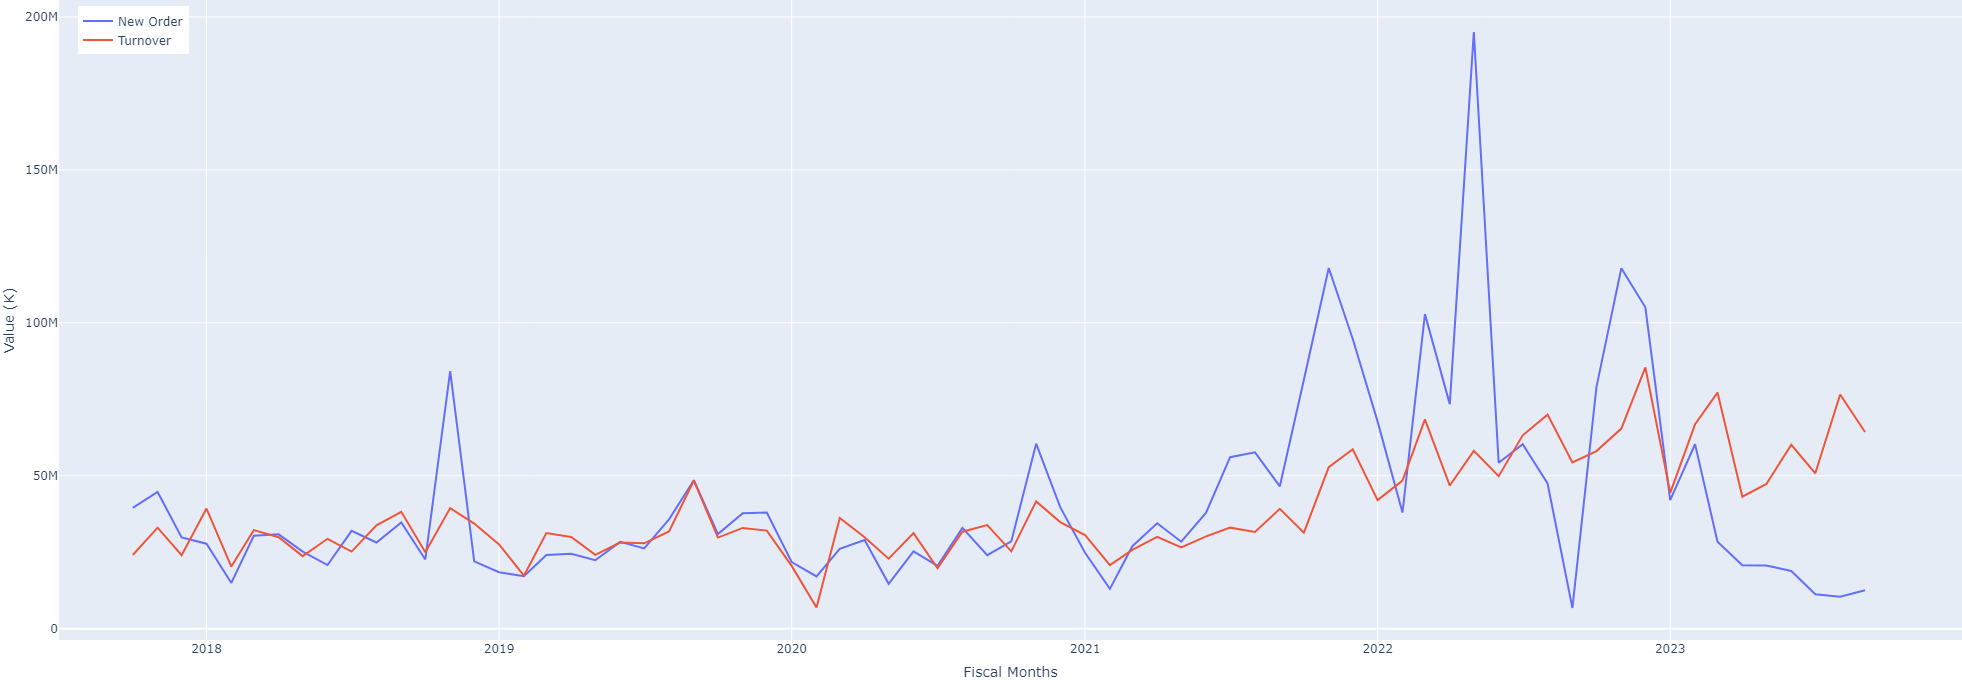

In [243]:
import plotly.graph_objects as go

order = ts.groupby('month')['OR'].sum()
turnover = ts.groupby('month')['TO'].sum()

plot_order = go.Scatter(x=order.index, y=order, mode='lines', name='New Order')
plot_turnover = go.Scatter(x=turnover.index, y=turnover, mode='lines', name='Turnover')

fig = go.Figure([plot_order, plot_turnover])
fig.update_layout(
    height=680, margin={'t':0, 'b':0, 'l':0, 'r':0},
    xaxis=dict(title="Fiscal Months", dtick='M12', range=['2017-07-01','2023-12-31']),
    yaxis=dict(title="Value (K)"),
    legend=dict(x=0.01, y=0.99)
)
fig.show()

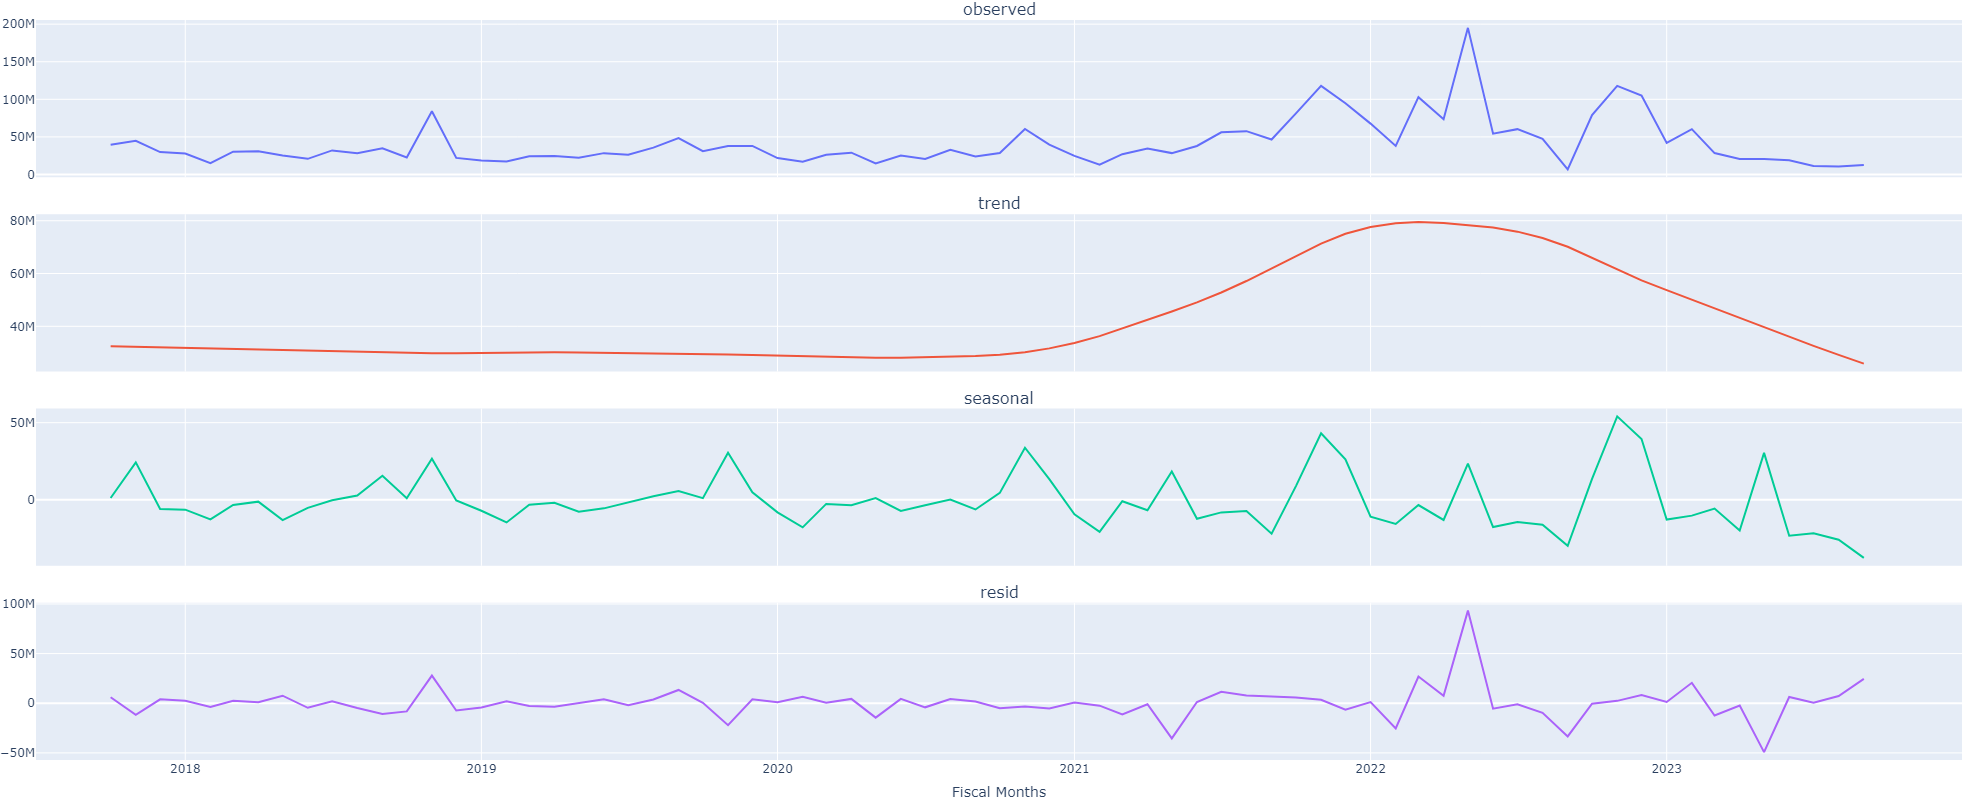

In [245]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, STL
decomposition = STL(order, period=12).fit()

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=['observed', 'trend', 'seasonal', 'resid']
)

x = df.index
fig.add_trace(go.Scatter(x=x, y=decomposition.observed), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.trend), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.seasonal), row=3, col=1)
fig.add_trace(go.Scatter(x=x, y=decomposition.resid), row=4, col=1)

fig.update_layout(
    height=800, margin={'t':20, 'b':0, 'l':0, 'r':0},
    xaxis4=dict(title="Fiscal Months", dtick='M12', range=['2017-07-01','2023-12-31']),
    showlegend=False
)
fig.show()

In [233]:
cols = ['PostDate', 'FiscalYear', 'AssignType', 'BuyerType', 'OrderNum', 'Territory', 'ProductLine', 'Sales', 'Buyer', 'AssignedCustomer', 'OR', 'TO']
ts[cols]

,PostDate,FiscalYear,AssignType,BuyerType,OrderNum,Territory,ProductLine,Sales,Buyer,AssignedCustomer,OR,TO
0,2017-10-15,FY18,Direct,Dealer,AKZ00000169,TER00000002,GBK00000000,VBE00000097,CUS00000051,ASS00000398,1259296.25,0.0
1,2017-10-15,FY18,Direct,Dealer,AKZ00000169,TER00000002,GBK00000003,VBE00000097,CUS00000051,ASS00000398,668811.00,0.0
2,2017-10-15,FY18,Direct,Dealer,AKZ00000198,TER00000005,GBK00000000,VBE00000099,CUS00000055,ASS00000582,129168.39,0.0
3,2017-10-15,FY18,Direct,Dealer,AKZ00000199,TER00000005,GBK00000000,VBE00000099,CUS00000055,ASS00000582,113177.36,0.0
4,2017-10-15,FY18,Direct,Dealer,AKZ00000199,TER00000005,GBK00000003,VBE00000099,CUS00000055,ASS00000582,27336.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
159913,2023-09-30,FY23,Assign_TO,Dealer,AKZ00013307,TER00000004,GBK00000005,VBE00000211,CUS00000021,ASS00000969,118724.22,0.0
159914,2023-09-30,FY23,Balance_TO,Dealer,AKZ00013309,TER00000002,GBK00000006,VBE00000166,CUS00000050,ASS00000397,-7930.54,0.0
159915,2023-09-30,FY23,Assign_TO,Dealer,AKZ00013309,TER00000004,GBK00000006,VBE00000170,CUS00000050,ASS00001027,7930.54,0.0
159916,2023-09-30,FY23,Assign_TO,Dealer,AKZ00013311,TER00000003,GBK00000011,VBE00000135,CUS00000029,ASS00001890,5187.60,0.0
